In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from pathlib import Path
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load DEM and Climate Dataset
# -------------------------------

dem = rioxarray.open_rasterio("data/DEM/DEM_Tut1.tif", masked=True).squeeze()
print("DEM x bounds:", float(dem.x.min()), "to", float(dem.x.max()))
print("DEM y bounds:", float(dem.y.min()), "to", float(dem.y.max()))

climate_ds = xr.open_dataset("data/extracted_climate_var/AS_climate_var_ds.nc")
variables = list(climate_ds.data_vars.keys())
print("Variables:", variables)

# Interpolate each variable to the DEM grid (downsampled for speed)
dem_lons = dem.x.values[::10]
dem_lats = dem.y.values[::10]
interp_vars = []

for var in variables:
    da = climate_ds[var]
    if "lat" in da.dims and "lon" in da.dims:
        interp = da.interp(lat=dem_lats, lon=dem_lons, method="linear")
        interp_vars.append(interp)
        print(f"Interpolated: {var}, shape: {interp.shape}")

# -------------------------------
# 2. Load Station Rainfall
# -------------------------------

rainfall_dir = Path("data/mon_rainfall")
station_meta = pd.read_csv("data/as_raingage_list2.csv")
station_rain = {}

for csv_file in rainfall_dir.glob("*_monthly.csv"):
    df = pd.read_csv(csv_file)
    station_id = csv_file.stem.replace("_monthly", "")
    df['year_month'] = pd.to_datetime(df['year_month'].astype(str))
    df = df.dropna(subset=['monthly_total_precip_in'])
    df['month_str'] = df['year_month'].dt.strftime('%Y-%m')
    station_rain[station_id] = dict(zip(df['month_str'], df['monthly_total_precip_in']))

print(f"\nLoaded rainfall for {len(station_rain)} stations.")

# -------------------------------
# 3. Build Features at Each Station Per Month
# -------------------------------

X_list = []
y_list = []
times = pd.to_datetime(climate_ds.time.values)
time_strs = times.strftime('%Y-%m')

for t_idx, t_val in enumerate(time_strs):
    for idx, row in station_meta.iterrows():
        sid = row['Station']
        lat = row['LAT']
        lon = row['LONG']
        
        if sid not in station_rain or t_val not in station_rain[sid]:
            continue
        
        rain_val = station_rain[sid][t_val]
        if pd.isna(rain_val):
            continue
        
        # Extract interpolated climate values at station point
        features = []
        for var_interp in interp_vars:
            try:
                val = float(var_interp.isel(time=t_idx).interp(lat=lat, lon=lon).values)
            except:
                val = np.nan


DEM x bounds: -170.84696025293798 to -170.54557137248796
DEM y bounds: -14.374160704249647 to -14.229623671259647
Variables: ['air_temp_diff_1000_500', 'air_2m', 'hgt_1000', 'hgt_500', 'omega_500', 'pottmp_diff_1000_500', 'pottmp_diff_1000_850', 'pr_wtr', 'shum_700', 'shum_925', 'zon_moist_700', 'zon_moist_925', 'merid_moist_700', 'merid_moist_925', 'skin_temp', 'slp']
Interpolated: air_temp_diff_1000_500, shape: (804, 157, 326)
Interpolated: air_2m, shape: (804, 157, 326)
Interpolated: hgt_1000, shape: (804, 157, 326)
Interpolated: hgt_500, shape: (804, 157, 326)
Interpolated: omega_500, shape: (804, 157, 326)
Interpolated: pottmp_diff_1000_500, shape: (804, 157, 326)
Interpolated: pottmp_diff_1000_850, shape: (804, 157, 326)
Interpolated: pr_wtr, shape: (804, 157, 326)
Interpolated: shum_700, shape: (804, 157, 326)
Interpolated: shum_925, shape: (804, 157, 326)
Interpolated: zon_moist_700, shape: (804, 157, 326)
Interpolated: zon_moist_925, shape: (804, 157, 326)
Interpolated: merid_

In [3]:
print("Checking available rainfall samples by month:")
valid_months = 0
for m, arr in interpolated_rain.items():
    if not np.isnan(arr).all():
        valid_months += 1
print(f"{valid_months} months with usable interpolated rainfall.")


Checking available rainfall samples by month:
106 months with usable interpolated rainfall.


In [4]:
for station_id, rain_series in station_rain.items():
    print(station_id, list(rain_series.items())[:5])  # Just show a few


toa_ridge_WRCC [('2012-03', np.float64(nan)), ('2012-04', np.float64(5.120000000000001)), ('2012-05', np.float64(11.75)), ('2012-06', np.float64(7.320000000000001)), ('2012-07', np.float64(6.3100000000000005))]
airport80 [('1980-10', np.float64(21.479999999999997)), ('1980-11', np.float64(7.43)), ('1980-12', np.float64(13.439999999999998)), ('1981-01', np.float64(14.25)), ('1981-02', np.float64(14.23))]
malaeimi [('2003-02', np.float64(1.200787402)), ('2003-03', np.float64(15.342519686)), ('2003-04', np.float64(12.598425195)), ('2003-05', np.float64(21.992125981999997)), ('2003-06', np.float64(9.425196851))]
vaipito2000 [('1958-07', np.float64(nan)), ('1958-08', np.float64(nan)), ('1958-09', np.float64(nan)), ('1958-10', np.float64(nan)), ('1958-11', np.float64(nan))]
fagaitua [('1997-12', np.float64(3.3999999999999995)), ('1998-01', np.float64(12.5)), ('1998-02', np.float64(nan)), ('1998-03', np.float64(nan)), ('1998-04', np.float64(1.9))]
maloata [('2000-03', np.float64(20.618110235)

DEM x bounds: -170.84696025293798 to -170.54557137248796
DEM y bounds: -14.374160704249647 to -14.229623671259647
Fixed climate longitudes: [-172.5 -170.  -167.5]
Coarse climate shape: (804, 3, 3)
Coarse climate dims: ('time', 'lat', 'lon')
Downsampled DEM lons shape: (326,)
Downsampled DEM lats shape: (157,)
Interpolated climate shape: (804, 157, 326)


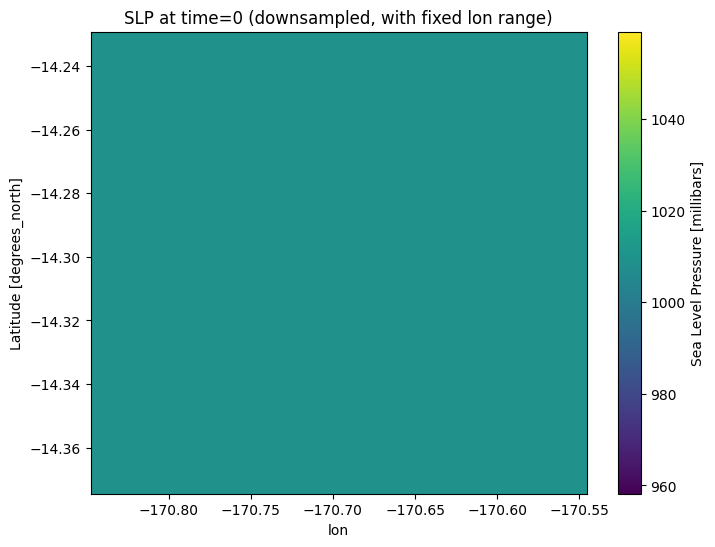

In [2]:
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt

# -------------------------------------
# 1. Load DEM
# -------------------------------------
dem = rioxarray.open_rasterio("data/DEM/DEM_Tut1.tif", masked=True).squeeze()
print("DEM x bounds:", float(dem.x.min()), "to", float(dem.x.max()))
print("DEM y bounds:", float(dem.y.min()), "to", float(dem.y.max()))

# -------------------------------------
# 2. Load Climate Data & Fix Longitude Range
# -------------------------------------
climate_ds = xr.open_dataset("data/extracted_climate_var/AS_climate_var_ds.nc")

# SHIFT climate_ds['lon'] from 0–360 to -180–180
fixed_lons = np.where(climate_ds['lon'].values > 180,
                      climate_ds['lon'].values - 360,
                      climate_ds['lon'].values)
climate_ds = climate_ds.assign_coords(lon=("lon", fixed_lons))

print("Fixed climate longitudes:", climate_ds['lon'].values)

# Let's pick one variable, e.g. 'slp'
coarse_climate = climate_ds['slp']  # shape: (time, lat, lon)

print("Coarse climate shape:", coarse_climate.shape)
print("Coarse climate dims:", coarse_climate.dims)

# -------------------------------------
# 3. Downsample the DEM Grid (Optional)
# -------------------------------------
downsample_factor = 10
dem_lons = dem.x.values[::downsample_factor]
dem_lats = dem.y.values[::downsample_factor]
print("Downsampled DEM lons shape:", dem_lons.shape)
print("Downsampled DEM lats shape:", dem_lats.shape)

# -------------------------------------
# 4. Interpolate
# -------------------------------------
interp_climate = coarse_climate.interp(lon=dem_lons, lat=dem_lats, method='nearest')
print("Interpolated climate shape:", interp_climate.shape)

# -------------------------------------
# 5. Visualize
# -------------------------------------
time_index = 0
plt.figure(figsize=(8,6))
interp_climate.isel(time=time_index).plot(cmap='viridis')
plt.title("SLP at time=0 (downsampled, with fixed lon range)")
plt.show()


In [19]:
test_month = "2000-12"
points = []
values = []
for idx, row in station_meta.iterrows():
    station_id = row["Station"]
    lat = row["LAT"]
    lon = row["LONG"]
    if test_month in station_rain.get(station_id, {}):
        rain_val = station_rain[station_id][test_month]
        points.append((lon, lat))
        values.append(rain_val)

points = np.array(points)
values = np.array(values)
print("Points for", test_month, ":", points)
print("Values for", test_month, ":", values)

if len(points) >= 3:
    grid_lon, grid_lat = np.meshgrid(coarse_lons, coarse_lats)
    grid_points = np.vstack([grid_lon.ravel(), grid_lat.ravel()]).T
    # Switch method to 'nearest' to avoid NaNs outside convex hull
    grid_rain = griddata(points, values, grid_points, method='nearest')
    print("Interpolated grid for", test_month, ":\n", grid_rain.reshape((3,3)))
else:
    print("Not enough data for", test_month)


Points for 2000-12 : [[-170.6889944   -14.26560556]
 [-170.6939944   -14.27060556]
 [-170.7101944   -14.28294444]
 [-170.5534389   -14.28532778]
 [-170.61705     -14.26727222]
 [-170.7141667   -14.33166667]
 [-170.7739944   -14.30949167]
 [-170.7469444   -14.34180556]
 [-170.7392722   -14.31754722]
 [-170.8126056   -14.30726944]]
Values for 2000-12 : [10.8503937  11.8        12.2         8.1        11.7        11.37795276
         nan 12.38582678         nan 11.09055118]
Interpolated grid for 2000-12 :
 [[11.09055118  8.1         8.1       ]
 [11.09055118  8.1         8.1       ]
 [11.09055118 12.38582678  8.1       ]]
